- **This code computes the decomposed solution of a Closed-Loop DRTO problem.**
- Using tracking objective function
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC N.B.:strategy 2 not working
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file
- Studying the impact of loading the subproblems (increasing the number of reactors)

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [ ]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Distributions, LaTeXStrings

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [ ]:
# Sampling time
T = 1 #[h]

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 2.4 # for tight constraints: 1.9 | for loose constraints: 5.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [ ]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\Preliminary calculations\\BioreactorModel", DataFrame; header=false);

CL-DRTO configuration

In [ ]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1)# p = 8 *controller horizon  
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [ ]:
function DRTO_matrices(nReactors,nScenarios)
    # ATTENTION: Used for the monolithic solution. It generates an array of models
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the models based on a fixed index grid that is generated based on the number of scenarios
    
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors])
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

In [ ]:
function DRTO_matrix(nReactors,nScenario,nScenTotal)
    # ATTENTION: Used for the decomposed solution. If generates a single model
    # This function extracts the model of interest based on the index "nScenario"
  
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
    # nScenTotal - total number of scenario used in the stochastic optimization
    
    if nScenTotal == 1
        index_temp = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenTotal-1)) for ii in 1:nScenTotal]
        index_temp = indexScen[nScenario]
    end
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [ ]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: check *Different Strategies to solve constrained MPC within CLDRTO* --> Preliminary calculation

In [ ]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1/nReactors], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Testing Monolithic CLDRTO* --> Preliminary calculations/Linear Bioreactor
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO* --> Preliminary calculation

In [ ]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 10000
bigM_u = 10000

# weight complementarity relaxation OF term
pi_bar = 10^2;

In [ ]:
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)

    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
     if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################    
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
      
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

<div>
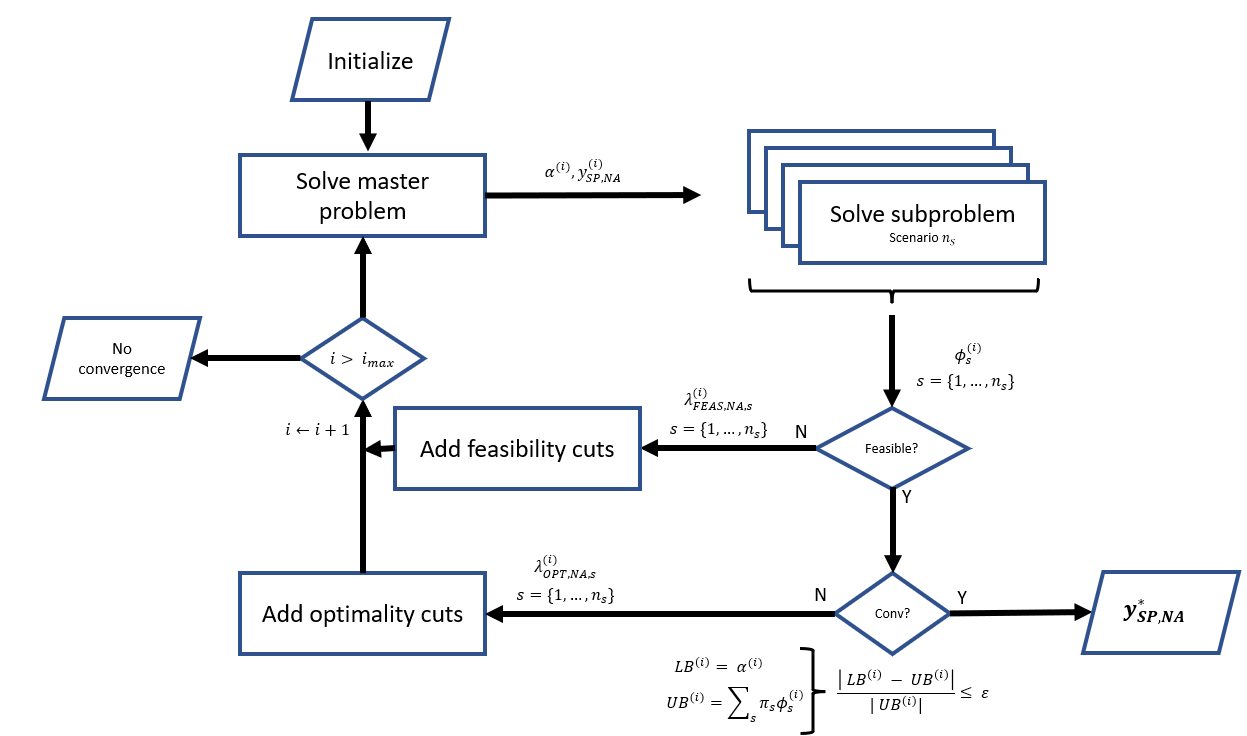
</div>

## Modeling Subproblem

In [ ]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    
    # recomputing the number of total scenarios based on scenario probability and the fact that the scenarios have the same probability
    nScenTotal = ceil(Int,1/pScen)    
    drto = DRTO_matrix(nReac,nScen,nScenTotal)
    
    # Define subproblem model  #== 3
    if option == 3 || option == 1 
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    if option == 1
        @variable(sub, u_w_c[1:pD,1:m]) # inputs w/o clipping
    
        # input clipping 
        @variable(sub, mu_lb[1:pD,1:m] ≥ 0)
        @variable(sub, eta_lb[1:pD,1:m] ≥ 0)
        @variable(sub, mu_ub[1:pD,1:m] ≥ 0)
        @variable(sub, eta_ub[1:pD,1:m] ≥ 0)       
    end

    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################
    ################
    # MPC solution #
    ################ 
    if option == 1
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u_w_c[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u_w_c[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u_w_c[kk,:] + cfT[kk]' .== 0)

        # input clipping
        @constraint(sub, ic_1[kk = 1:mD,uu = 1:m], u[kk,uu] == u_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu])
        @constraint(sub, ic_2[kk = 1:mD,uu = 1:m], (uMax - u0) - u[kk,uu] == eta_ub[kk,uu])
        @constraint(sub, ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6)
        @constraint(sub, ic_4[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMin - u0) == eta_lb[kk,uu])
        @constraint(sub, ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6)
    
    elseif option == 2
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end

    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum((yDRTO[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        # if binaries are used for solving const. MPC
        if option == 2
            muArray = value.(mu_g)
                   
            uubBinArray = value.(Y_ub)
            ulbBinArray = value.(Y_lb)
            
            merge!(outputDict,Dict('μ'=> muArray))
            merge!(outputDict,Dict('o' => ulbBinArray))
            merge!(outputDict,Dict('p' => uubBinArray))
            
        end
        
        # if MPCC is used for solving const. MPC
        if option == 3
            muArray = value.(mu_g)
            
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        # ! soft bounds on y
        #delete_lower_bound.(yDRTO[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
            
            # ! soft bounds on u
            for kk in 1:mD
                for uu in 1:m
                    delete(sub, MPC_c_upper[kk,uu])
                    delete(sub, MPC_c_lower[kk,uu])
                end
            end
        end
        
        ####################
        # Set up variables #
        ####################         
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        #@variable(sub, delta_y_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
            
            # slacks
            @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
            @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)

        end
        
        ###########################
        # Always-feasible problem #
        ###########################        
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])
        
        #@constraint(sub, soft_y_lower[kk=1:pD], (0 - y0) - yDRTO[kk] ≤ delta_y_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
            
            # adding a constraint to guarantee feasibility
            @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
            @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

Modeling Bender's Decomposition

In [ ]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 1e-3; 

In [ ]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = 0.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            display("DB: opt gap = $(gap)")

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii >= benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations
    
    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => time_dec,
                         'ϕ' => objFun_dec,
                         'm' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec)
                        
        
        return outputFun
        
    else
        # recomputing values
        uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
        yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
        yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]

        #calling values of the solved problem
        return Dict('ϕ' => objFun_dec, 
                    'd' => yspSol_dec, 
                    't' => time_dec,
                    'm' => time_max_dec, 
                    'i' => iter_dec,
                    'g' => optGap_dec,
                    'u' => uArray, 
                    'y' => yArray, 
                    's' => yspArray)
    end     
end;

# Checking the performance of the methods in terms of time vs. nReac

In [23]:
# testing the number of reactors in series (chosen arbitrarily as the same number of scenarios)
nReactMax = 50

#option = 1 --> Unconstrained MPC
#option = 2 --> Constrained MPC with binaries --> DOES NOT WORK YET!
#option = 3 --> Constrained MPC with MPCC
opti = 3

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_r = Matrix{Float64}(undef,2,nReactMax) 
# computed objective function
solObjTraj_r = Matrix{Float64}(undef,2,nReactMax) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_r = Vector{Float64}(undef,nReactMax) 
# number of iterations
iterTraj_r = Vector{Float64}(undef,nReactMax) 
# optimality gap
optGapTraj_r = Vector{Float64}(undef,nReactMax) 

# number of reactors in parallel
nScenarios = 1
#equiprobable scenarios
pScenarios = 1.0/nScenarios

# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,opti); 

for rr = 1:nReactMax
    display("evaluating $(rr) reactors in parallel | option $(opti)")
        
    #number os reactors
    nReac = rr
    # Number of states
    nx = 2*nReac
        
    # Possible initial conditions (deviation form)
    xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReac,1])
    uInit_0 = 1.0 - u0
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)

    # solving decomposed problem    
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)
        
    # for plotting
    solTimeTraj_r[1,rr] = sol_m_Dict['t']
    solTimeTraj_r[2,rr] = sol_d_Dict['t']
    
    solObjTraj_r[1,rr] = sol_m_Dict['ϕ']
    solObjTraj_r[2,rr] = sol_d_Dict['ϕ']

    solTimeMaxTraj_r[rr] = sol_d_Dict['m']
    iterTraj_r[rr] = sol_d_Dict['i'] 
    optGapTraj_r[rr] = sol_d_Dict['g']

end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"evaluating 1 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007667075592494"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7566241215116879"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7075375857029185"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6257226759660225"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5014239146041639"

">>>>>> iteration 9:O"

"DB: opt gap = 0.4916689968741358"

">>>>>> iteration 10:O"

"DB: opt gap = 0.2921334363362807"

">>>>>> iteration 11:O"

"DB: opt gap = 0.2864882252812361"

">>>>>> iteration 12:O"

"DB: opt gap = 0.28266667736858136"

">>>>>> iteration 13:O"

"DB: opt gap = 0.2776933668776269"

">>>>>> iteration 14:O"

"DB: opt gap = 0.01853115159720852"

">>>>>> iteration 15:O"

"DB: opt gap = 0.01724081628882437"

">>>>>> iteration 16:O"

"DB: opt gap = 0.01719239231618855"

">>>>>> iteration 17:O"

"DB: opt gap = 1.8114333818164405e-5"

"evaluating 2 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.950075186202999"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7359498807631178"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5374496513923062"

">>>>>> iteration 7:O"

"DB: opt gap = 0.528424757920487"

">>>>>> iteration 8:O"

"DB: opt gap = 0.46660395062339927"

">>>>>> iteration 9:O"

"DB: opt gap = 0.016689236082721087"

">>>>>> iteration 10:O"

"DB: opt gap = 0.016560901117821714"

">>>>>> iteration 11:O"

"DB: opt gap = 0.016463087614755074"

">>>>>> iteration 12:O"

"DB: opt gap = 0.01627868495901094"

">>>>>> iteration 13:O"

"DB: opt gap = 0.016233306177821292"

">>>>>> iteration 14:O"

"DB: opt gap = 0.015758892285271376"

">>>>>> iteration 15:O"

"DB: opt gap = 0.015646639086306393"

">>>>>> iteration 16:O"

"DB: opt gap = 0.015096111109505778"

">>>>>> iteration 17:O"

"DB: opt gap = 0.014994603585329669"

">>>>>> iteration 18:O"

"DB: opt gap = 5.340041852464904e-5"

"evaluating 3 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802033742418407"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7093838853712368"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5495769559262836"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4354267743559576"

">>>>>> iteration 8:O"

"DB: opt gap = 0.39918523018851865"

">>>>>> iteration 9:O"

"DB: opt gap = 0.38617886516563804"

">>>>>> iteration 10:O"

"DB: opt gap = 0.024181825191930215"

">>>>>> iteration 11:O"

"DB: opt gap = 2.576115360801536e-5"

"evaluating 4 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9451659702554736"

">>>>>> iteration 5:O"

"DB: opt gap = 0.8827967664404763"

">>>>>> iteration 6:O"

"DB: opt gap = 0.054379019993288924"

">>>>>> iteration 7:O"

"DB: opt gap = 0.05352218611968895"

">>>>>> iteration 8:O"

"DB: opt gap = 0.052092947759117325"

">>>>>> iteration 9:O"

"DB: opt gap = 0.05180728257927619"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 0.05131215755857043"

">>>>>> iteration 12:O"

"DB: opt gap = 0.05067180734944474"

">>>>>> iteration 13:O"

"DB: opt gap = 0.00010539037375606887"

"evaluating 5 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445402120734214"

">>>>>> iteration 5:O"

"DB: opt gap = 0.697307561516515"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108221934098853"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4982039340576661"

">>>>>> iteration 8:O"

"DB: opt gap = 0.36958753147800805"

">>>>>> iteration 9:O"

"DB: opt gap = 0.437792090261518"

">>>>>> iteration 10:O"

"DB: opt gap = 0.07393400497363202"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07345258514865217"

">>>>>> iteration 12:O"

"DB: opt gap = 0.07259315137108448"

">>>>>> iteration 13:O"

"DB: opt gap = 0.07213022784980856"

">>>>>> iteration 14:O"

"DB: opt gap = 0.0004170962104336273"

"evaluating 6 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.980203487157734"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7093842191724488"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6962046116471489"

">>>>>> iteration 7:O"

"DB: opt gap = 0.0296514514139602"

">>>>>> iteration 8:O"

"DB: opt gap = 0.028791580828500675"

">>>>>> iteration 9:O"

"DB: opt gap = 0.028478458903002882"

">>>>>> iteration 10:O"

"DB: opt gap = 0.02775057722719373"

">>>>>> iteration 11:O"

"DB: opt gap = 0.027097982521333126"

">>>>>> iteration 12:O"

"DB: opt gap = 0.02682555859770338"

">>>>>> iteration 13:O"

"DB: opt gap = 0.026893441783690502"

">>>>>> iteration 14:O"

"DB: opt gap = 4.1551317746342024e-5"

"evaluating 7 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7302773846004565"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6759311011788478"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5302895621784953"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5113174105784702"

">>>>>> iteration 9:O"

"DB: opt gap = 0.31140957880932074"

">>>>>> iteration 10:O"

"DB: opt gap = 0.34429267365204375"

">>>>>> iteration 11:O"

"DB: opt gap = 0.011808809521351257"

">>>>>> iteration 12:O"

"DB: opt gap = 0.011722760049933948"

">>>>>> iteration 13:O"

"DB: opt gap = 0.011696472316086769"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 8 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007665649311333"

">>>>>> iteration 5:O"

"DB: opt gap = 0.696271259347818"

">>>>>> iteration 6:O"

"DB: opt gap = 0.563636917096344"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5248524838378347"

">>>>>> iteration 8:O"

"DB: opt gap = 0.47512832935235344"

">>>>>> iteration 9:O"

"DB: opt gap = 0.07154413188390582"

">>>>>> iteration 10:O"

"DB: opt gap = 0.07012027261482487"

">>>>>> iteration 11:O"

"DB: opt gap = 0.06967867134848427"

">>>>>> iteration 12:O"

"DB: opt gap = 0.06462867737415137"

">>>>>> iteration 13:O"

"DB: opt gap = 0.06349386370631212"

">>>>>> iteration 14:O"

"DB: opt gap = 0.0631416895740352"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0006216171948761654"

"evaluating 9 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007666558750642"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962716483645804"

">>>>>> iteration 6:O"

"DB: opt gap = 0.650586566778547"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6215027108803"

">>>>>> iteration 8:O"

"DB: opt gap = 0.41437905212445375"

">>>>>> iteration 9:O"

"DB: opt gap = 0.45186437930440265"

">>>>>> iteration 10:O"

"DB: opt gap = 0.036078137698313875"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03516108790847087"

">>>>>> iteration 12:O"

"DB: opt gap = 0.0347439252835429"

">>>>>> iteration 13:O"

"DB: opt gap = 0.03483270873888339"

">>>>>> iteration 14:O"

"DB: opt gap = 6.881283317048995e-5"

"evaluating 10 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007666060983467"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962715198307611"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6505862786411931"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4895537383921786"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5229527905791028"

">>>>>> iteration 9:O"

"DB: opt gap = 0.02953841034357555"

">>>>>> iteration 10:O"

"DB: opt gap = 0.029223799222403663"

">>>>>> iteration 11:O"

"DB: opt gap = 0.0285460514573981"

">>>>>> iteration 12:O"

"DB: opt gap = 0.028256211250269364"

">>>>>> iteration 13:O"

"DB: opt gap = 0.027730395639069854"

">>>>>> iteration 14:O"

"DB: opt gap = 0.02745872443765373"

">>>>>> iteration 15:O"

"DB: opt gap = 0.02687032802481677"

">>>>>> iteration 16:O"

"DB: opt gap = 0.02661877762505219"

">>>>>> iteration 17:O"

"DB: opt gap = 0.00016223332572475141"

"evaluating 11 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.744540032991547"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454010906096372"

">>>>>> iteration 6:O"

"DB: opt gap = 0.512868502772435"

">>>>>> iteration 7:O"

"DB: opt gap = 0.46140637681656216"

">>>>>> iteration 8:O"

"DB: opt gap = 0.42313130345959327"

">>>>>> iteration 9:O"

"DB: opt gap = 0.4432023916188754"

">>>>>> iteration 10:O"

"DB: opt gap = 0.07279486033893198"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07152630474448783"

">>>>>> iteration 12:O"

"DB: opt gap = 0.00048418462724580155"

"evaluating 12 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 0.9565931125954272"

">>>>>> iteration 7:O"

"DB: opt gap = 0.05249163157164497"

">>>>>> iteration 8:O"

">>>>>> iteration 9:F"

"DB: opt gap = 0.05137380186163623"

">>>>>> iteration 10:O"

"DB: opt gap = 0.0398566982103029"

">>>>>> iteration 11:O"

"DB: opt gap = 0.0006387182636802269"

"evaluating 13 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802033481982277"

">>>>>> iteration 5:O"

"DB: opt gap = 0.8611206027481668"

">>>>>> iteration 6:O"

"DB: opt gap = 0.8428716577568803"

">>>>>> iteration 7:O"

"DB: opt gap = 0.05016481593102024"

">>>>>> iteration 8:O"

"DB: opt gap = 0.04953917147693356"

">>>>>> iteration 9:O"

"DB: opt gap = 0.04851626617586"

">>>>>> iteration 10:O"

"DB: opt gap = 0.0480464713277158"

">>>>>> iteration 11:O"

"DB: opt gap = 0.04539080266991891"

">>>>>> iteration 12:O"

"DB: opt gap = 0.04131461898917923"

">>>>>> iteration 13:O"

"DB: opt gap = 0.040815667317024996"

">>>>>> iteration 14:O"

"DB: opt gap = 0.03976411829116553"

">>>>>> iteration 15:O"

"DB: opt gap = 0.03930806585299345"

">>>>>> iteration 16:O"

"DB: opt gap = 0.0003767645857591953"

"evaluating 14 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9500753863210029"

">>>>>> iteration 5:O"

"DB: opt gap = 0.735950291984904"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6872568124546266"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5209177166639537"

">>>>>> iteration 8:O"

"DB: opt gap = 0.2995212478391194"

">>>>>> iteration 9:O"

">>>>>> iteration 10:F"

"DB: opt gap = 0.2884667297545597"

">>>>>> iteration 11:O"

"DB: opt gap = 0.28617734469846806"

">>>>>> iteration 12:O"

"DB: opt gap = 0.012316023792556719"

">>>>>> iteration 13:O"

"DB: opt gap = 0.012237256924647635"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 15 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445403233291582"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973075571607341"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108219452076583"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4780624051988464"

">>>>>> iteration 8:O"

"DB: opt gap = 0.39816355617997545"

">>>>>> iteration 9:O"

"DB: opt gap = 0.4375040029479929"

">>>>>> iteration 10:O"

"DB: opt gap = 0.08468727310866883"

">>>>>> iteration 11:O"

"DB: opt gap = 0.08410056379609872"

">>>>>> iteration 12:O"

"DB: opt gap = 0.08283130225840211"

">>>>>> iteration 13:O"

"DB: opt gap = 0.08227225840252399"

">>>>>> iteration 14:O"

"DB: opt gap = 0.0008867039038627775"

"evaluating 16 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445402373303649"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973076091390377"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108221566627185"

">>>>>> iteration 7:O"

"DB: opt gap = 0.49820393767673"

">>>>>> iteration 8:O"

"DB: opt gap = 0.3695880359185054"

">>>>>> iteration 9:O"

"DB: opt gap = 0.39449308924569654"

">>>>>> iteration 10:O"

"DB: opt gap = 0.34885924767097354"

">>>>>> iteration 11:O"

"DB: opt gap = 0.3864394049115177"

">>>>>> iteration 12:O"

"DB: opt gap = 0.08080010878618728"

">>>>>> iteration 13:O"

"DB: opt gap = 0.07933878275787755"

">>>>>> iteration 14:O"

"DB: opt gap = 0.0010954152790569357"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0010936304345977844"

">>>>>> iteration 16:O"

"DB: opt gap = 0.0010923320227377014"

">>>>>> iteration 17:O"

"DB: opt gap = 0.0010912330011973092"

">>>>>> iteration 18:O"

"DB: opt gap = 1.2068663604796624e-7"

"evaluating 17 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445401003593229"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454012654435564"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5128686731760783"

">>>>>> iteration 7:O"

"DB: opt gap = 0.46140657213916414"

">>>>>> iteration 8:O"

"DB: opt gap = 0.4231316272283298"

">>>>>> iteration 9:O"

"DB: opt gap = 0.443202115094006"

">>>>>> iteration 10:O"

"DB: opt gap = 0.07279527548141418"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07152759882315311"

">>>>>> iteration 12:O"

"DB: opt gap = 0.00048412865336049126"

"evaluating 18 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445400516485932"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454015383973682"

">>>>>> iteration 6:O"

"DB: opt gap = 0.655515623913811"

">>>>>> iteration 7:O"

"DB: opt gap = 0.026213531811318854"

">>>>>> iteration 8:O"

"DB: opt gap = 0.025945353621078287"

">>>>>> iteration 9:O"

"DB: opt gap = 0.025324025766668225"

">>>>>> iteration 10:O"

"DB: opt gap = 0.02523239164749663"

">>>>>> iteration 11:O"

"DB: opt gap = 0.02454282387529714"

">>>>>> iteration 12:O"

"DB: opt gap = 0.024458913668349604"

">>>>>> iteration 13:O"

"DB: opt gap = 5.231455889438708e-5"

"evaluating 19 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445402058575763"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973076337094979"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108221616643039"

">>>>>> iteration 7:O"

"DB: opt gap = 0.49820432190028335"

">>>>>> iteration 8:O"

"DB: opt gap = 0.4902598164866025"

">>>>>> iteration 9:O"

"DB: opt gap = 0.4297004798275883"

">>>>>> iteration 10:O"

"DB: opt gap = 0.44783089250774155"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07665754496488106"

">>>>>> iteration 12:O"

"DB: opt gap = 0.07526931453175054"

">>>>>> iteration 13:O"

"DB: opt gap = 0.00030260619731462354"

"evaluating 20 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007667447282006"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962715823302755"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6505866080162389"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6215026120831121"

">>>>>> iteration 8:O"

"DB: opt gap = 0.41437901878847394"

">>>>>> iteration 9:O"

"DB: opt gap = 0.4518638892524485"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03608037632101321"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03578883703738265"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

"DB: opt gap = 0.03572337378321754"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 21 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711302433522864"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451806490424783"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362601747787273"

">>>>>> iteration 8:O"

"DB: opt gap = 0.701516502789612"

">>>>>> iteration 9:O"

"DB: opt gap = 0.026588620630206727"

">>>>>> iteration 10:O"

"DB: opt gap = 0.025754058373576378"

">>>>>> iteration 11:O"

"DB: opt gap = 0.025490820305654773"

">>>>>> iteration 12:O"

"DB: opt gap = 0.02498180653979335"

">>>>>> iteration 13:O"

"DB: opt gap = 0.024331328817677734"

">>>>>> iteration 14:O"

"DB: opt gap = 0.02424571461762416"

">>>>>> iteration 15:O"

"DB: opt gap = 0.024258636439186583"

">>>>>> iteration 16:O"

"DB: opt gap = 0.024029652002031218"

">>>>>> iteration 17:O"

"DB: opt gap = 4.542825672208535e-5"

"evaluating 22 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711302416530303"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451806502026772"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362601737076927"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015165030468091"

">>>>>> iteration 9:O"

"DB: opt gap = 0.026589451939279637"

">>>>>> iteration 10:O"

"DB: opt gap = 0.026315448094699777"

">>>>>> iteration 11:O"

"DB: opt gap = 0.026214130989216766"

">>>>>> iteration 12:O"

"DB: opt gap = 0.025978646146554922"

">>>>>> iteration 13:O"

"DB: opt gap = 0.02521706144792063"

">>>>>> iteration 14:O"

"DB: opt gap = 0.0249659968470273"

">>>>>> iteration 15:O"

"DB: opt gap = 0.02425964594656705"

">>>>>> iteration 16:O"

"DB: opt gap = 0.02417504928552545"

">>>>>> iteration 17:O"

"DB: opt gap = 0.023006286875273858"

">>>>>> iteration 18:O"

"DB: opt gap = 0.022802785023990142"

">>>>>> iteration 19:O"

"DB: opt gap = 0.022366120624508"

">>>>>> iteration 20:O"

"DB: opt gap = 0.022296160971387435"

">>>>>> iteration 21:O"

"DB: opt gap = 0.00010785045023282271"

"evaluating 23 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445401666939173"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454013200353848"

">>>>>> iteration 6:O"

"DB: opt gap = 0.512868575750726"

">>>>>> iteration 7:O"

"DB: opt gap = 0.46140703259267135"

">>>>>> iteration 8:O"

"DB: opt gap = 0.48174635007917854"

">>>>>> iteration 9:O"

"DB: opt gap = 0.059483288482546706"

">>>>>> iteration 10:O"

"DB: opt gap = 0.05913189286796545"

">>>>>> iteration 11:O"

"DB: opt gap = 0.057447681975442304"

">>>>>> iteration 12:O"

"DB: opt gap = 0.05655298142864158"

">>>>>> iteration 13:O"

"DB: opt gap = 0.00025005729752503546"

"evaluating 24 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007667360886025"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962715678413557"

">>>>>> iteration 6:O"

"DB: opt gap = 0.650586615797654"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6215028104663303"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5862655914286545"

">>>>>> iteration 9:O"

"DB: opt gap = 0.02376889504207854"

">>>>>> iteration 10:O"

"DB: opt gap = 0.023578207607909515"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

"DB: opt gap = 0.023257853389267766"

">>>>>> iteration 13:O"

"DB: opt gap = 0.02266568239226577"

">>>>>> iteration 14:O"

"DB: opt gap = 0.02238866215850204"

">>>>>> iteration 15:O"

"DB: opt gap = 0.022231411607628624"

">>>>>> iteration 16:O"

"DB: opt gap = 0.021775347684886436"

">>>>>> iteration 17:O"

"DB: opt gap = 3.138856024168383e-5"

"evaluating 25 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007666054412714"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962712794110556"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5636368565901255"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5248524870154538"

">>>>>> iteration 8:O"

"DB: opt gap = 0.47512842872993444"

">>>>>> iteration 9:O"

"DB: opt gap = 0.07154271929643374"

">>>>>> iteration 10:O"

"DB: opt gap = 0.06770176850064501"

">>>>>> iteration 11:O"

"DB: opt gap = 0.06659443430321785"

">>>>>> iteration 12:O"

"DB: opt gap = 0.06462441492310653"

">>>>>> iteration 13:O"

"DB: opt gap = 0.06348769268518564"

">>>>>> iteration 14:O"

"DB: opt gap = 0.06313460603626857"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0006232696478821363"

"evaluating 26 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445404323683287"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973080443678513"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7110843453838213"

">>>>>> iteration 7:O"

"DB: opt gap = 0.04112059503481471"

">>>>>> iteration 8:O"

"DB: opt gap = 0.04057291559377408"

">>>>>> iteration 9:O"

"DB: opt gap = 0.040225640754681644"

">>>>>> iteration 10:O"

"DB: opt gap = 3.950311758958171e-5"

"evaluating 27 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802032991260999"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7093841375876195"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6962047831835179"

">>>>>> iteration 7:O"

"DB: opt gap = 0.029650497643834133"

">>>>>> iteration 8:O"

"DB: opt gap = 0.028790675511873216"

">>>>>> iteration 9:O"

"DB: opt gap = 0.028477380726439135"

">>>>>> iteration 10:O"

"DB: opt gap = 0.027749365340155308"

">>>>>> iteration 11:O"

"DB: opt gap = 0.02709787630234063"

">>>>>> iteration 12:O"

"DB: opt gap = 0.02699690998753019"

">>>>>> iteration 13:O"

"DB: opt gap = 0.027014034892937206"

">>>>>> iteration 14:O"

"DB: opt gap = 0.026915175476260104"

">>>>>> iteration 15:O"

"DB: opt gap = 4.835091040697825e-5"

"evaluating 28 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007666183702882"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962714874785262"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6505864675234005"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6215024712266596"

">>>>>> iteration 8:O"

"DB: opt gap = 0.4143790659376129"

">>>>>> iteration 9:O"

"DB: opt gap = 0.45186436402792335"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03607920467289948"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03578674360149101"

">>>>>> iteration 12:O"

"DB: opt gap = 0.03499733873563662"

">>>>>> iteration 13:O"

"DB: opt gap = 0.034586443960056085"

">>>>>> iteration 14:O"

"DB: opt gap = 0.03431999337210891"

">>>>>> iteration 15:O"

"DB: opt gap = 9.305016178450665e-5"

"evaluating 29 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7302774551712689"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6759312645607248"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5302895585166482"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5113175300206105"

">>>>>> iteration 9:O"

"DB: opt gap = 0.31140933104382174"

">>>>>> iteration 10:O"

"DB: opt gap = 0.3442920447052978"

">>>>>> iteration 11:O"

"DB: opt gap = 0.011809550913437904"

">>>>>> iteration 12:O"

"DB: opt gap = 0.011575462701631508"

">>>>>> iteration 13:O"

"DB: opt gap = 0.01150677369648218"

">>>>>> iteration 14:O"

"DB: opt gap = 0.011376389279978666"

">>>>>> iteration 15:O"

"DB: opt gap = 4.837532069640369e-6"

"evaluating 30 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711302616687563"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451807122742269"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362603207070143"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015168652751019"

">>>>>> iteration 9:O"

"DB: opt gap = 0.0265914801475009"

">>>>>> iteration 10:O"

"DB: opt gap = 0.026316447299750637"

">>>>>> iteration 11:O"

"DB: opt gap = 0.026039472888025796"

">>>>>> iteration 12:O"

"DB: opt gap = 0.02498519802170374"

">>>>>> iteration 13:O"

"DB: opt gap = 0.024776697735693645"

">>>>>> iteration 14:O"

"DB: opt gap = 0.024687392895684265"

">>>>>> iteration 15:O"

"DB: opt gap = 0.024262162957414884"

">>>>>> iteration 16:O"

"DB: opt gap = 0.024177247739334416"

">>>>>> iteration 17:O"

"DB: opt gap = 0.023603024877547268"

">>>>>> iteration 18:O"

"DB: opt gap = 0.02338811191490536"

">>>>>> iteration 19:O"

"DB: opt gap = 0.023004089785227236"

">>>>>> iteration 20:O"

"DB: opt gap = 7.447169144997907e-5"

"evaluating 31 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711301750656631"

">>>>>> iteration 6:O"

"DB: opt gap = 0.8973076545262103"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5358121873333839"

">>>>>> iteration 8:O"

"DB: opt gap = 0.519964002985124"

">>>>>> iteration 9:O"

"DB: opt gap = 0.47801427475450214"

">>>>>> iteration 10:O"

"DB: opt gap = 0.45786375654036343"

">>>>>> iteration 11:O"

"DB: opt gap = 0.3024647697341977"

">>>>>> iteration 12:O"

"DB: opt gap = 0.3950952222963088"

">>>>>> iteration 13:O"

"DB: opt gap = 0.07664293339620852"

">>>>>> iteration 14:O"

"DB: opt gap = 0.07377613001062469"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0007038068992043983"

"evaluating 32 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 0.9359592274862363"

">>>>>> iteration 7:O"

"DB: opt gap = 0.8185189813819669"

">>>>>> iteration 8:O"

"DB: opt gap = 0.4847549713411334"

">>>>>> iteration 9:O"

"DB: opt gap = 0.42773211510057063"

">>>>>> iteration 10:O"

"DB: opt gap = 0.29144771397868113"

">>>>>> iteration 11:O"

"DB: opt gap = 0.28550894256818327"

">>>>>> iteration 12:O"

"DB: opt gap = 0.4179820413938233"

">>>>>> iteration 13:O"

"DB: opt gap = 0.4114246431437411"

">>>>>> iteration 14:O"

"DB: opt gap = 0.08425877752801698"

">>>>>> iteration 15:O"

"DB: opt gap = 0.0010153845394841213"

">>>>>> iteration 16:O"

"DB: opt gap = 0.0010147443798099055"

">>>>>> iteration 17:O"

"DB: opt gap = 0.0010138569194352374"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

"DB: opt gap = 0.0010126922686722931"

">>>>>> iteration 20:O"

"DB: opt gap = 0.0010114136575629458"

">>>>>> iteration 21:O"

"DB: opt gap = 1.410422483261584e-6"

"evaluating 33 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711301619383192"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451805602150439"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362601387332617"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015164331339496"

">>>>>> iteration 9:O"

"DB: opt gap = 0.026588762183693458"

">>>>>> iteration 10:O"

"DB: opt gap = 0.025755057179808114"

">>>>>> iteration 11:O"

"DB: opt gap = 0.025658018205791916"

">>>>>> iteration 12:O"

"DB: opt gap = 0.024983394321720778"

">>>>>> iteration 13:O"

"DB: opt gap = 0.024774835895436657"

">>>>>> iteration 14:O"

"DB: opt gap = 0.02468667626854455"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 0.024747007240506356"

">>>>>> iteration 17:O"

"DB: opt gap = 0.024559629024151076"

">>>>>> iteration 18:O"

"DB: opt gap = 2.6338934797445303e-5"

"evaluating 34 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6957100092888755"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6486296194987425"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6040376088262976"

">>>>>> iteration 8:O"

"DB: opt gap = 0.5647557346929328"

">>>>>> iteration 9:O"

"DB: opt gap = 0.49138615793678453"

">>>>>> iteration 10:O"

"DB: opt gap = 0.3130608470939742"

">>>>>> iteration 11:O"

"DB: opt gap = 0.27877482892455435"

">>>>>> iteration 12:O"

"DB: opt gap = 0.2705350461975011"

">>>>>> iteration 13:O"

"DB: opt gap = 0.020355391923397442"

">>>>>> iteration 14:O"

"DB: opt gap = 0.02029133617109053"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 0.020149569957742922"

">>>>>> iteration 17:O"

"DB: opt gap = 0.020117824375719483"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 35 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802032853332294"

">>>>>> iteration 5:O"

"DB: opt gap = 0.709383879443229"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5495766709651034"

">>>>>> iteration 7:O"

"DB: opt gap = 0.3035257166226901"

">>>>>> iteration 8:O"

"DB: opt gap = 0.29376212187999823"

">>>>>> iteration 9:O"

"DB: opt gap = 0.290176336482894"

">>>>>> iteration 10:O"

"DB: opt gap = 0.28565041158892773"

">>>>>> iteration 11:O"

"DB: opt gap = 0.2791215884094179"

">>>>>> iteration 12:O"

"DB: opt gap = 0.01097465167728977"

">>>>>> iteration 13:O"

"DB: opt gap = 0.010769379645966849"

">>>>>> iteration 14:O"

"DB: opt gap = 5.632451788286421e-6"

"evaluating 36 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802032382558296"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7093840309519782"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6962044678979195"

">>>>>> iteration 7:O"

"DB: opt gap = 0.029651406458591406"

">>>>>> iteration 8:O"

"DB: opt gap = 0.028791523090174468"

">>>>>> iteration 9:O"

"DB: opt gap = 0.02847915950057106"

">>>>>> iteration 10:O"

"DB: opt gap = 0.02827868170228157"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

"DB: opt gap = 0.027961948359563737"

">>>>>> iteration 13:O"

"DB: opt gap = 0.021689624994981928"

">>>>>> iteration 14:O"

"DB: opt gap = 0.00037478880281604046"

"evaluating 37 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711301275539551"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451805870492917"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362601459023507"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015168745817796"

">>>>>> iteration 9:O"

"DB: opt gap = 0.02658839704931423"

">>>>>> iteration 10:O"

"DB: opt gap = 0.025753806552379747"

">>>>>> iteration 11:O"

"DB: opt gap = 0.025491334142808283"

">>>>>> iteration 12:O"

"DB: opt gap = 0.025322556908147064"

">>>>>> iteration 13:O"

"DB: opt gap = 0.02433158717903435"

">>>>>> iteration 14:O"

"DB: opt gap = 0.024246486240674887"

">>>>>> iteration 15:O"

"DB: opt gap = 0.02406088204131986"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 38 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8791865060098033"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6114829719991223"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5664705562996981"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5818305186006061"

">>>>>> iteration 8:O"

"DB: opt gap = 0.03790175585299312"

">>>>>> iteration 9:O"

"DB: opt gap = 0.0370894209547223"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03654842357397547"

">>>>>> iteration 11:O"

"DB: opt gap = 4.2227801431577326e-5"

"evaluating 39 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802032275717926"

">>>>>> iteration 5:O"

"DB: opt gap = 0.709384097139482"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6962045907111212"

">>>>>> iteration 7:O"

"DB: opt gap = 0.02964993225618273"

">>>>>> iteration 8:O"

"DB: opt gap = 0.0287910709888078"

">>>>>> iteration 9:O"

"DB: opt gap = 0.028676465940083398"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

"DB: opt gap = 0.028471470254522218"

">>>>>> iteration 12:O"

"DB: opt gap = 1.2227702509841522e-5"

"evaluating 40 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445400466374278"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454012966397541"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5128681753662128"

">>>>>> iteration 7:O"

"DB: opt gap = 0.368670967567959"

">>>>>> iteration 8:O"

"DB: opt gap = 0.40820440776591266"

">>>>>> iteration 9:O"

"DB: opt gap = 0.05033723695368033"

">>>>>> iteration 10:O"

"DB: opt gap = 0.04960015524582604"

">>>>>> iteration 11:O"

"DB: opt gap = 0.04913652511227771"

">>>>>> iteration 12:O"

"DB: opt gap = 0.00018515914539013665"

"evaluating 41 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007665606792895"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6962715554578498"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6505866193943362"

">>>>>> iteration 7:O"

"DB: opt gap = 0.6215025274149265"

">>>>>> iteration 8:O"

"DB: opt gap = 0.414379687909752"

">>>>>> iteration 9:O"

"DB: opt gap = 0.436939638189425"

">>>>>> iteration 10:O"

"DB: opt gap = 0.3861887805864491"

">>>>>> iteration 11:O"

"DB: opt gap = 0.37558346948498955"

">>>>>> iteration 12:O"

"DB: opt gap = 0.0368801037702739"

">>>>>> iteration 13:O"

"DB: opt gap = 0.03563171083207659"

">>>>>> iteration 14:O"

"DB: opt gap = 0.03521031870009549"

">>>>>> iteration 15:O"

"DB: opt gap = 0.00011618929789008141"

"evaluating 42 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445399775971477"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6454011524373244"

">>>>>> iteration 6:O"

"DB: opt gap = 0.512868458396509"

">>>>>> iteration 7:O"

"DB: opt gap = 0.46140695025885364"

">>>>>> iteration 8:O"

"DB: opt gap = 0.48174588113001243"

">>>>>> iteration 9:O"

"DB: opt gap = 0.05948188798124471"

">>>>>> iteration 10:O"

"DB: opt gap = 0.058525885205803575"

">>>>>> iteration 11:O"

"DB: opt gap = 0.05687265310895262"

">>>>>> iteration 12:O"

"DB: opt gap = 0.00023351232310890143"

"evaluating 43 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.8007669762099768"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7566241906532989"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7075374979754079"

">>>>>> iteration 7:O"

"DB: opt gap = 0.47877239378274505"

">>>>>> iteration 8:O"

"DB: opt gap = 0.4119335692184941"

">>>>>> iteration 9:O"

"DB: opt gap = 0.38898921261801767"

">>>>>> iteration 10:O"

"DB: opt gap = 0.08025293600867607"

">>>>>> iteration 11:O"

"DB: opt gap = 0.07707558727792675"

">>>>>> iteration 12:O"

"DB: opt gap = 0.0005254323316748519"

"evaluating 44 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711302712381905"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451806984666819"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362602923062035"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015164932021256"

">>>>>> iteration 9:O"

"DB: opt gap = 0.026589418959472297"

">>>>>> iteration 10:O"

"DB: opt gap = 0.026315394192674372"

">>>>>> iteration 11:O"

"DB: opt gap = 0.026213155798460005"

">>>>>> iteration 12:O"

"DB: opt gap = 0.024982197127318296"

">>>>>> iteration 13:O"

"DB: opt gap = 0.024331042050346655"

">>>>>> iteration 14:O"

"DB: opt gap = 0.024099410483881072"

">>>>>> iteration 15:O"

"DB: opt gap = 0.02425837166106743"

">>>>>> iteration 16:O"

"DB: opt gap = 0.02402914475846855"

">>>>>> iteration 17:O"

"DB: opt gap = 0.023005494571134155"

">>>>>> iteration 18:O"

"DB: opt gap = 0.022801849580814843"

">>>>>> iteration 19:O"

"DB: opt gap = 0.02236484641054354"

">>>>>> iteration 20:O"

"DB: opt gap = 0.022294370064461364"

">>>>>> iteration 21:O"

"DB: opt gap = 0.00010877782131364224"

"evaluating 45 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445401952788862"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973075744505204"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108221629947515"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4982039490982333"

">>>>>> iteration 8:O"

"DB: opt gap = 0.3695880269807323"

">>>>>> iteration 9:O"

"DB: opt gap = 0.39449360839119574"

">>>>>> iteration 10:O"

"DB: opt gap = 0.36163755099671524"

">>>>>> iteration 11:O"

"DB: opt gap = 0.02124083380461169"

">>>>>> iteration 12:O"

"DB: opt gap = 0.021050434346515667"

">>>>>> iteration 13:O"

"DB: opt gap = 0.020701988114548386"

">>>>>> iteration 14:O"

"DB: opt gap = 0.020522659218479768"

">>>>>> iteration 15:O"

"DB: opt gap = 0.020160342728050062"

">>>>>> iteration 16:O"

"DB: opt gap = 0.020097633279311206"

">>>>>> iteration 17:O"

"DB: opt gap = 1.9916575527254587e-5"

"evaluating 46 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.9802034796674727"

">>>>>> iteration 5:O"

"DB: opt gap = 0.7093841947203617"

">>>>>> iteration 6:O"

"DB: opt gap = 0.6962047001560925"

">>>>>> iteration 7:O"

"DB: opt gap = 0.029651251216835654"

">>>>>> iteration 8:O"

"DB: opt gap = 0.029378310040589228"

">>>>>> iteration 9:O"

"DB: opt gap = 0.027751126354344346"

">>>>>> iteration 10:O"

"DB: opt gap = 0.027550032742984405"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

"DB: opt gap = 0.027517975382422195"

">>>>>> iteration 13:O"

"DB: opt gap = 0.027292607756740216"

">>>>>> iteration 14:O"

"DB: opt gap = 0.026693555077014854"

">>>>>> iteration 15:O"

"DB: opt gap = 5.276875911590999e-5"

"evaluating 47 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 0.9711303758593643"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7451807110180926"

">>>>>> iteration 7:O"

"DB: opt gap = 0.7362604195321709"

">>>>>> iteration 8:O"

"DB: opt gap = 0.7015167949247676"

">>>>>> iteration 9:O"

"DB: opt gap = 0.02658908562933254"

">>>>>> iteration 10:O"

"DB: opt gap = 0.02575459818992844"

">>>>>> iteration 11:O"

"DB: opt gap = 0.02549136021545258"

">>>>>> iteration 12:O"

"DB: opt gap = 0.02498364084347774"

">>>>>> iteration 13:O"

"DB: opt gap = 0.024775118710831667"

">>>>>> iteration 14:O"

"DB: opt gap = 0.024686942602747942"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

"DB: opt gap = 0.024747215034541834"

">>>>>> iteration 17:O"

"DB: opt gap = 0.024520909605785263"

">>>>>> iteration 18:O"

"DB: opt gap = 0.02452145140815741"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 48 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445401281692837"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973077829300579"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7110840277995233"

">>>>>> iteration 7:O"

"DB: opt gap = 0.041123077165614585"

">>>>>> iteration 8:O"

"DB: opt gap = 0.04092104594676135"

">>>>>> iteration 9:O"

"DB: opt gap = 0.03933851910060973"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03915590777348464"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

"DB: opt gap = 0.03875752189165887"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

">>>>>> iteration 15:F"

">>>>>> iteration 16:F"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"evaluating 49 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 1.0"

">>>>>> iteration 5:O"

"DB: opt gap = 1.0"

">>>>>> iteration 6:O"

"DB: opt gap = 0.7996360605930734"

">>>>>> iteration 7:O"

"DB: opt gap = 0.5344741541300974"

">>>>>> iteration 8:O"

"DB: opt gap = 0.49176432327032704"

">>>>>> iteration 9:O"

"DB: opt gap = 0.5110509209067264"

">>>>>> iteration 10:O"

"DB: opt gap = 0.03612929996073459"

">>>>>> iteration 11:O"

"DB: opt gap = 0.03370994935843297"

">>>>>> iteration 12:O"

"DB: opt gap = 0.03339588155448774"

">>>>>> iteration 13:O"

"DB: opt gap = 6.901994636261213e-5"

"evaluating 50 reactors in parallel | option 3"

"DB: opt gap = 1.0"

">>>>>> iteration 1:O"

"DB: opt gap = 1.0"

">>>>>> iteration 2:O"

"DB: opt gap = 1.0"

">>>>>> iteration 3:O"

"DB: opt gap = 1.0"

">>>>>> iteration 4:O"

"DB: opt gap = 0.7445402582073081"

">>>>>> iteration 5:O"

"DB: opt gap = 0.6973075160550728"

">>>>>> iteration 6:O"

"DB: opt gap = 0.5108219761829403"

">>>>>> iteration 7:O"

"DB: opt gap = 0.4982037224467172"

">>>>>> iteration 8:O"

"DB: opt gap = 0.3695880321793799"

">>>>>> iteration 9:O"

"DB: opt gap = 0.3944930597189039"

">>>>>> iteration 10:O"

"DB: opt gap = 0.3488597113944293"

">>>>>> iteration 11:O"

"DB: opt gap = 0.3738293123489286"

">>>>>> iteration 12:O"

"DB: opt gap = 0.04759113424471812"

">>>>>> iteration 13:O"

"DB: opt gap = 0.04733711831004934"

">>>>>> iteration 14:O"

"DB: opt gap = 8.536644032311777e-5"

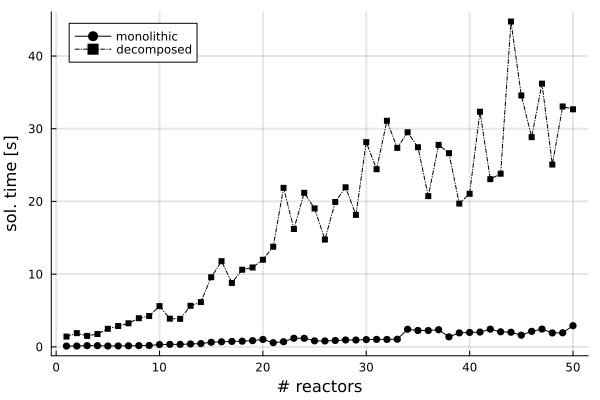

In [24]:
# solution time
p5 = plot(1:nReactMax,solTimeTraj_r[1,:],
    xlabel="# reactors",
    ylabel="sol. time [s]",
    marker=:circle,
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p5 = plot!(1:nReactMax,solTimeTraj_r[2,:],
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p5)
#savefig(p5,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_SolTime.pdf");

In [ ]:
# solution time
p5b = plot(1:nReactMax,solTimeTraj_r[1,:],
    xlabel="# reactors",
    ylabel="sol. time [s]",
    marker=:circle,
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p5b = plot!(1:nReactMax,solTimeMaxTraj_r,
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p5b)
#savefig(p5b,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_SolMaxTime.pdf");

In [ ]:
# objective function (parallel)
p5c = plot(1:nReactMax,100*(solObjTraj_r[2,:] - solObjTraj_r[1,:])./solObjTraj_r[1,:],
    xlabel="# reactors", 
    ylabel="objective function difference [%]",
    marker=:xcross, 
    markercolor = :black,
    linecolor = :black,
    label="",
    dpi=600)

display(p5c)
#savefig(p5c,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_OFComp.pdf");

In [ ]:
p6 = plot(1:nReactMax,iterTraj_r,
    xlabel="# reactors", 
    ylabel="# iterations",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    yticks=range(0,150,step=10),
    gridlinewidth=2,
    dpi=600)

display(p6)
#savefig(p6,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_BenIter.pdf");

In [ ]:
p8 = plot(1:nReactMax,optGapTraj_r,
    yscale=:log10,
    xlabel="# reactors", 
    ylabel=L"T_{benders}",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    gridlinewidth=2,
    dpi=600)

display(p8)
#savefig(p8,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C2_BenOptGap.pdf");

Creating table to show the results

In [ ]:
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30 40 50] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_r[1,tt])
    push!(table_solTime_D, solTimeTraj_r[2,tt])
    push!(table_of_M, solObjTraj_r[1,tt])
    push!(table_of_D, solObjTraj_r[2,tt])
    push!(table_perChange, 100*(solObjTraj_r[2,tt] - solObjTraj_r[1,tt])/solObjTraj_r[1,tt])
end

df_reac = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [ ]:
display("Analysis: # of Reactors")
display(df_reac)